## This file aims to forecast Citi Bike rentals using a dataset spanning from 2021 to 2024.

## Import necessary Libraries

In [1]:
#install necessary packages
!pip install seaborn
!pip install prophet
!pip install scikit-learn
!pip install plotly
!pip install ipywidgets

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
ERROR: unknown command "install scikit-learn"
Defaulting to user installation because normal site-packages is not writeable
ERROR: unknown command "install ipywidgets"


In [2]:
# importing required libraries
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from datetime import datetime
from pyspark.sql import SparkSession
from pyspark.sql.window import Window
from pyspark.sql.functions import col, count, date_format, to_date, year, unix_timestamp, round, avg, sum, hour, dayofweek, lit
from pyspark.sql.types import StructType, StructField, StringType, DecimalType, BooleanType, FloatType, DoubleType, TimestampType, IntegerType

sns.set_style('whitegrid')

In [3]:
!echo $SPARK_MASTER_ADDRESS

spark://notch081.ipoib.int.chpc.utah.edu:7080


In [4]:
!echo $SPARK_MASTER_OOD_ADDRESS
!echo $SPARK_WORKER1_OOD_ADDRESS
!echo $SPARK_WORKER2_OOD_ADDRESS

https://ondemand-class.chpc.utah.edu/rnode/notch081.ipoib.int.chpc.utah.edu/8086
https://ondemand-class.chpc.utah.edu/rnode/notch081.ipoib.int.chpc.utah.edu/8087
https://ondemand-class.chpc.utah.edu/rnode/notch082.ipoib.int.chpc.utah.edu/8084


In [5]:
from pyspark.sql import SparkSession
import os
spark = SparkSession.builder \
    .master(os.getenv('SPARK_MASTER_ADDRESS')) \
    .appName("Spark-application") \
    .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/04/30 19:32:13 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/04/30 19:32:15 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
24/04/30 19:32:15 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
24/04/30 19:32:15 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.


### Manual inspection of dataset for each year from 2021-2024

In [6]:
directory_path = "data/3_years"

# Get a list of all CSV files in the directory
csv_files = [os.path.join(directory_path, file) for file in os.listdir(directory_path) if file.endswith(".csv")]

In [7]:
data_2021 = 'data/3_years/JC-202101-citibike-tripdata.csv'
data_2022 = 'data/3_years/JC-202201-citibike-tripdata.csv'
data_2023 = 'data/3_years/JC-202301-citibike-tripdata.csv'
data_2024 = 'data/3_years/JC-202401-citibike-tripdata.csv'

data_years = [data_2021, data_2022, data_2023, data_2024]
for years in data_years:
    objects = spark.read.csv(years, sep=',',inferSchema=True, header=True)
    print(years)
    objects.printSchema()

data/3_years/JC-202101-citibike-tripdata.csv
root
 |-- tripduration: integer (nullable = true)
 |-- starttime: timestamp (nullable = true)
 |-- stoptime: timestamp (nullable = true)
 |-- start station id: integer (nullable = true)
 |-- start station name: string (nullable = true)
 |-- start station latitude: double (nullable = true)
 |-- start station longitude: double (nullable = true)
 |-- end station id: integer (nullable = true)
 |-- end station name: string (nullable = true)
 |-- end station latitude: double (nullable = true)
 |-- end station longitude: double (nullable = true)
 |-- bikeid: integer (nullable = true)
 |-- usertype: string (nullable = true)
 |-- birth year: integer (nullable = true)
 |-- gender: integer (nullable = true)



data/3_years/JC-202201-citibike-tripdata.csv
root
 |-- ride_id: string (nullable = true)
 |-- rideable_type: string (nullable = true)
 |-- started_at: timestamp (nullable = true)
 |-- ended_at: timestamp (nullable = true)
 |-- start_station_name: string (nullable = true)
 |-- start_station_id: string (nullable = true)
 |-- end_station_name: string (nullable = true)
 |-- end_station_id: string (nullable = true)
 |-- start_lat: double (nullable = true)
 |-- start_lng: double (nullable = true)
 |-- end_lat: double (nullable = true)
 |-- end_lng: double (nullable = true)
 |-- member_casual: string (nullable = true)



data/3_years/JC-202301-citibike-tripdata.csv
root
 |-- ride_id: string (nullable = true)
 |-- rideable_type: string (nullable = true)
 |-- started_at: timestamp (nullable = true)
 |-- ended_at: timestamp (nullable = true)
 |-- start_station_name: string (nullable = true)
 |-- start_station_id: string (nullable = true)
 |-- end_station_name: string (nullable = true)
 |-- end_station_id: string (nullable = true)
 |-- start_lat: double (nullable = true)
 |-- start_lng: double (nullable = true)
 |-- end_lat: double (nullable = true)
 |-- end_lng: double (nullable = true)
 |-- member_casual: string (nullable = true)

data/3_years/JC-202401-citibike-tripdata.csv
root
 |-- ride_id: string (nullable = true)
 |-- rideable_type: string (nullable = true)
 |-- started_at: timestamp (nullable = true)
 |-- ended_at: timestamp (nullable = true)
 |-- start_station_name: string (nullable = true)
 |-- start_station_id: string (nullable = true)
 |-- end_station_name: string (nullable = true)
 |-- end_sta

#### As we can see the dataset in inconsistent in column names. Hence, we need some data preprocessing before preparing our final merged dataset.

#### Identical columns as per need: {"starttime" : "started_at", "start station name" : "start_station_name", "end station name" : "end_station_name", start station latitude", "start_lat","end station latitude", "end_lat", "start station longitude", "start_lng" , "end station longitude", "end_lng"}

#### After preprocessing, We created a merged dataframe by merging all the csv present in our dataset. We have also done feature engineering so that we only consider those column which is needed for our task.

In [8]:
start_time = datetime.now()

# Read the first CSV file to create the initial DataFrame
objects = spark.read.csv(csv_files[0], header=True, inferSchema=True)

# Rename the files to make them consistent
objects = objects.withColumnRenamed("starttime", "started_at") \
                 .withColumnRenamed("stoptime", "ended_at") \
                 .withColumnRenamed("start station name", "start_station_name") \
                 .withColumnRenamed("end station name", "end_station_name") \
                 .withColumnRenamed("start station latitude", "start_lat") \
                 .withColumnRenamed("end station latitude", "end_lat") \
                 .withColumnRenamed("start station longitude", "start_lng") \
                 .withColumnRenamed("end station longitude", "end_lng") 

# Feature engineering to select only need columns
objects=objects.select("started_at","ended_at","start_station_name","end_station_name","start_lat","start_lng","end_lat","end_lng")

# Loop through the remaining CSV files and union them with the initial DataFrame
for file in csv_files[1:]:
    objects_temp = spark.read.csv(file, header=True, inferSchema=True)

    # Rename the files to make them consistent
    objects_temp = objects_temp.withColumnRenamed("starttime", "started_at") \
                 .withColumnRenamed("stoptime", "ended_at") \
                 .withColumnRenamed("start station name", "start_station_name") \
                 .withColumnRenamed("end station name", "end_station_name") \
                 .withColumnRenamed("start station latitude", "start_lat") \
                 .withColumnRenamed("end station latitude", "end_lat") \
                 .withColumnRenamed("start station longitude", "start_lng") \
                 .withColumnRenamed("end station longitude", "end_lng") 

    # Feature engineering to select only need columns
    objects_temp=objects_temp.select("started_at","ended_at","start_station_name","end_station_name","start_lat","start_lng","end_lat","end_lng")

    #Merging the dataframe
    objects = objects.union(objects_temp)

end_time = datetime.now()

# Show the merged dataframe
objects.show()

+--------------------+--------------------+------------------+--------------------+------------------+------------------+-----------------+------------------+
|          started_at|            ended_at|start_station_name|    end_station_name|         start_lat|         start_lng|          end_lat|           end_lng|
+--------------------+--------------------+------------------+--------------------+------------------+------------------+-----------------+------------------+
|2021-01-01 00:03:...|2021-01-01 00:08:...|      Manila & 1st|        Brunswick St|40.721650724879986|-74.04288411140442|       40.7241765|       -74.0506564|
|2021-01-01 00:23:...|2021-01-01 00:49:...|          Grand St|      Van Vorst Park| 40.71517767732029|-74.03768330812454|      40.71848892|     -74.047726625|
|2021-01-01 00:23:...|2021-01-01 00:48:...|          Grand St|      Van Vorst Park| 40.71517767732029|-74.03768330812454|      40.71848892|     -74.047726625|
|2021-01-01 00:31:...|2021-01-01 00:44:...|   

In [9]:
# Time required for data preprocessing and preparing the datafram
print("Time required for data preparation", (end_time - start_time))

Time required for data preparation 0:00:26.404611


In [10]:
objects.printSchema()

# Display the count of records
print("Number of records:", objects.count())

root
 |-- started_at: timestamp (nullable = true)
 |-- ended_at: timestamp (nullable = true)
 |-- start_station_name: string (nullable = true)
 |-- end_station_name: string (nullable = true)
 |-- start_lat: double (nullable = true)
 |-- start_lng: double (nullable = true)
 |-- end_lat: double (nullable = true)
 |-- end_lng: double (nullable = true)



Number of records: 2635053


### Data Cleaning:

#### We check for null values in our dataframe and remove those records from dataframe.

In [11]:
start_time = datetime.now()

null_counts_per_column = {}

# Iterate over each column and count null values
for column in objects.columns:
    null_count = objects.filter(col(column).isNull()).count()
    null_counts_per_column[column] = null_count

for column, cnt in null_counts_per_column.items():
    print(f"Column '{column}': {cnt} null values")

Column 'started_at': 0 null values
Column 'ended_at': 0 null values
Column 'start_station_name': 102 null values
Column 'end_station_name': 10319 null values
Column 'start_lat': 0 null values
Column 'start_lng': 0 null values
Column 'end_lat': 5193 null values
Column 'end_lng': 5193 null values


In [12]:
objects = objects.dropna()   # drop null values if any

print("Number of records after data cleaning:", objects.count())

Number of records after data cleaning: 2624714


#### Next, We calculate the duration of each ride in seconds by taking time difference between started_at time and ended_at time. We further ignore those rides having a ride duration less than a minute to ensure the accuracy and relevance of the analysis, as very short durations might not provide meaningful insights into bike usage patterns or user behavior.

In [13]:
# Convert 'started_at' and 'ended_at' columns to timestamps
objects = objects.withColumn('started_at', unix_timestamp(col('started_at'), 'yyyy-MM-dd HH:mm:ss').cast("timestamp"))
objects = objects.withColumn('ended_at', unix_timestamp(col('ended_at'), 'yyyy-MM-dd HH:mm:ss').cast("timestamp"))

# Calculate duration of each ride in seconds
objects = objects.withColumn('total_ride_duration_seconds', (col('ended_at').cast('long') - col('started_at').cast('long')))

objects.show()

+-------------------+-------------------+------------------+--------------------+------------------+------------------+-----------------+------------------+---------------------------+
|         started_at|           ended_at|start_station_name|    end_station_name|         start_lat|         start_lng|          end_lat|           end_lng|total_ride_duration_seconds|
+-------------------+-------------------+------------------+--------------------+------------------+------------------+-----------------+------------------+---------------------------+
|2021-01-01 00:03:35|2021-01-01 00:08:01|      Manila & 1st|        Brunswick St|40.721650724879986|-74.04288411140442|       40.7241765|       -74.0506564|                        266|
|2021-01-01 00:23:32|2021-01-01 00:49:16|          Grand St|      Van Vorst Park| 40.71517767732029|-74.03768330812454|      40.71848892|     -74.047726625|                       1544|
|2021-01-01 00:23:50|2021-01-01 00:48:12|          Grand St|      Van Vorst

In [14]:
# # Filter records with less than 1 minute duration and ignore this rides
# short_duration_rides = objects.filter(col('total_ride_duration_seconds') < 60)
# short_duration_rides.count()

In [15]:
# cosidering only ride having total_ride_duration_seconds > 1 min (60 sec) 
objects = objects.filter(col('total_ride_duration_seconds') >= 60)
objects.count()

2567803

In [16]:
end_time = datetime.now()

In [17]:
# Time required for data preprocessing and preparing the datafram
print("Time required for data cleaning:", (end_time - start_time))

Time required for data cleaning: 0:01:14.094541


# Exploratory data analysis

In this section, We address key inquiries posed by Citi Bike such as 
1. Where do Citi Bikers ride? 
2. When do they ride? 
3. How far do they go?
4. Which stations are most popular? 
5. What days of the week are most rides taken on?

## 1. Where do Citi Bikers ride? (Popular start and end stations)

In [18]:
start_time = datetime.now()

In [19]:
# We group by start station name and count the number of rides
start_station_counts = objects.groupBy('start_station_name').count().orderBy('count', ascending=False)

# We group by end station name and count the number of rides
end_station_counts = objects.groupBy('end_station_name').count().orderBy('count', ascending=False)

start_station_counts.show(10)   # top 10 starting stations
end_station_counts.show(10)     # top 10 ending stations

+--------------------+------+
|  start_station_name| count|
+--------------------+------+
|       Grove St PATH|120133|
|Hoboken Terminal ...| 98216|
|South Waterfront ...| 91683|
|Hoboken Terminal ...| 78547|
|        Newport Pkwy| 64755|
|        Newport PATH| 62613|
|       Hamilton Park| 62021|
|    Marin Light Rail| 54011|
|City Hall - Washi...| 53356|
|Hoboken Ave at Mo...| 50367|
+--------------------+------+
only showing top 10 rows



+--------------------+------+
|    end_station_name| count|
+--------------------+------+
|       Grove St PATH|130207|
|Hoboken Terminal ...| 95092|
|South Waterfront ...| 93005|
|Hoboken Terminal ...| 81239|
|        Newport Pkwy| 64837|
|        Newport PATH| 62831|
|       Hamilton Park| 62741|
|City Hall - Washi...| 54117|
|    Marin Light Rail| 53531|
|Hoboken Ave at Mo...| 52498|
+--------------------+------+
only showing top 10 rows



## 2. When do they ride? (Distribution of rides by time of day)

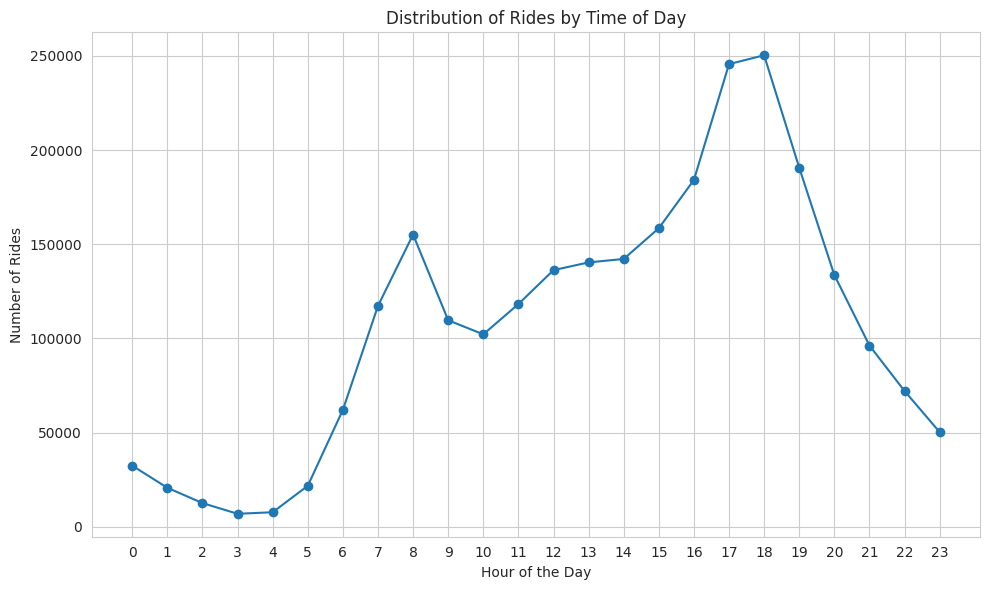

In [20]:
# As we need at what time do they ride, we first extract hour from the 'started_at' timestamp
objects = objects.withColumn('hour', hour('started_at'))

# next, we group by hour and count the number of rides
ride_hours = objects.groupBy('hour').count().orderBy('hour')

#convert to pandas
ride_hours_pd = ride_hours.toPandas()

# distribution of rides by time of day
plt.figure(figsize=(10, 6))
plt.plot(ride_hours_pd['hour'], ride_hours_pd['count'], marker='o', linestyle='-')
plt.title('Distribution of Rides by Time of Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Rides')
plt.xticks(range(24)) 
plt.grid(True)
plt.tight_layout()
plt.show()

## 3. How far do they go? (Average distance traveled per ride)

In [21]:
# distance traveled using start and end coordinates. The multiplication by 111.32 is used to convert the difference in latitude and longitude coordinates from degrees to kilometers.
objects = objects.withColumn('distance_km', lit(111.32) * (col('end_lat') - col('start_lat')) + lit(111.32) * (col('end_lng') - col('start_lng')) * col('end_lat'))

# average distance traveled per ride
average_distance = objects.agg({'distance_km': 'avg'}).collect()[0][0]

print("Average distance traveled per ride:", average_distance, "km")

Average distance traveled per ride: 1.2072265318757813 km


## 4. Which stations are most popular? (Top start and end stations)

In [22]:
start_station_counts.show(10)   # top 10 starting stations
end_station_counts.show(10)     # top 10 ending stations

+--------------------+------+
|  start_station_name| count|
+--------------------+------+
|       Grove St PATH|120133|
|Hoboken Terminal ...| 98216|
|South Waterfront ...| 91683|
|Hoboken Terminal ...| 78547|
|        Newport Pkwy| 64755|
|        Newport PATH| 62613|
|       Hamilton Park| 62021|
|    Marin Light Rail| 54011|
|City Hall - Washi...| 53356|
|Hoboken Ave at Mo...| 50367|
+--------------------+------+
only showing top 10 rows



+--------------------+------+
|    end_station_name| count|
+--------------------+------+
|       Grove St PATH|130207|
|Hoboken Terminal ...| 95092|
|South Waterfront ...| 93005|
|Hoboken Terminal ...| 81239|
|        Newport Pkwy| 64837|
|        Newport PATH| 62831|
|       Hamilton Park| 62741|
|City Hall - Washi...| 54117|
|    Marin Light Rail| 53531|
|Hoboken Ave at Mo...| 52498|
+--------------------+------+
only showing top 10 rows



## 5. What days of the week are most rides taken on? (Distribution of rides by day of the week)

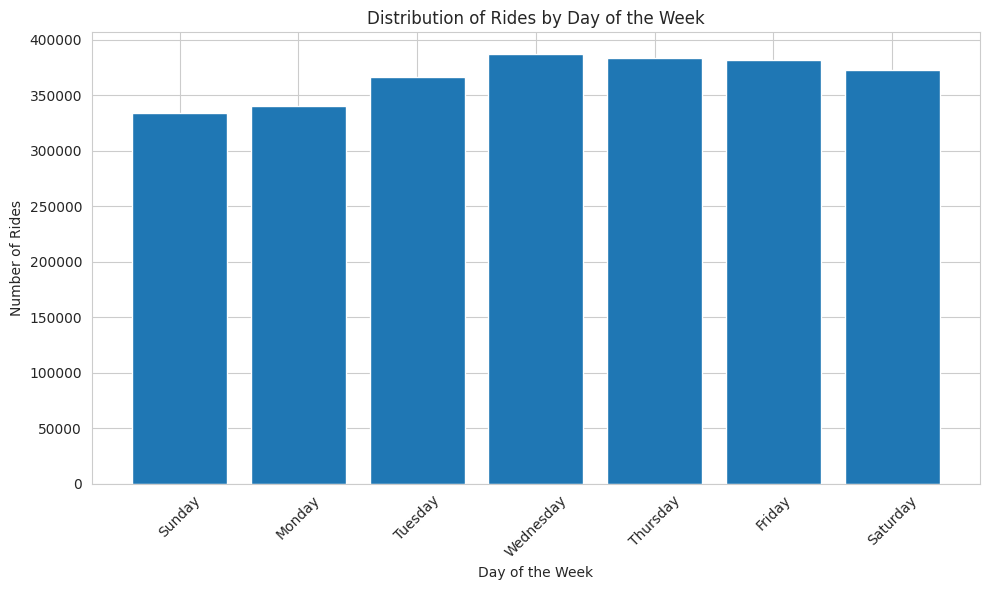

In [23]:
# Extract day of the week from the 'started_at' timestamp (1: Sunday, 2: Monday, ..., 7: Saturday)
objects = objects.withColumn('day_of_week', dayofweek('started_at'))

# Group by day of the week and count the number of rides
ride_days = objects.groupBy('day_of_week').count().orderBy('day_of_week')

# Convert DataFrame to Pandas DataFrame for plotting
ride_days_pd = ride_days.toPandas()

# Define the mapping of day of the week numbers to day names
day_names = {1: 'Sunday', 2: 'Monday', 3: 'Tuesday', 4: 'Wednesday', 5: 'Thursday', 6: 'Friday', 7: 'Saturday'}

# Map day of the week numbers to day names for better visualization
ride_days_pd['day_of_week'] = ride_days_pd['day_of_week'].map(day_names)

# Plot distribution of rides by day of the week
plt.figure(figsize=(10, 6))
plt.bar(ride_days_pd['day_of_week'], ride_days_pd['count'])
plt.title('Distribution of Rides by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Rides')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [24]:
end_time = datetime.now()
# Time required for data preprocessing and preparing the datafram
print("Time required for data cleaning:", (end_time - start_time))

Time required for data cleaning: 0:01:31.514939


#### Now we will start with forecasting. First, we will do feature engineering to consider the columns needed for our prophet model. Next, we will convert the dataframe into the form which we can feed it to phophet.

In [25]:
objects = objects.withColumn('started_at', date_format(col('started_at'), 'yyyy-MM-dd'))  
objects.printSchema()

root
 |-- started_at: string (nullable = true)
 |-- ended_at: timestamp (nullable = true)
 |-- start_station_name: string (nullable = true)
 |-- end_station_name: string (nullable = true)
 |-- start_lat: double (nullable = true)
 |-- start_lng: double (nullable = true)
 |-- end_lat: double (nullable = true)
 |-- end_lng: double (nullable = true)
 |-- total_ride_duration_seconds: long (nullable = true)
 |-- hour: integer (nullable = true)
 |-- distance_km: double (nullable = true)
 |-- day_of_week: integer (nullable = true)



In [26]:
# count number of rides on each start date
df = objects.groupBy('started_at').agg(count('*').alias('trips'))

# Sorting the dataFrame by date in ascending order
df = df.orderBy('started_at')

In [27]:
df.show()

+----------+-----+
|started_at|trips|
+----------+-----+
|2021-01-01|  206|
|2021-01-02|  504|
|2021-01-03|  159|
|2021-01-04|  415|
|2021-01-05|  380|
|2021-01-06|  432|
|2021-01-07|  419|
|2021-01-08|  412|
|2021-01-09|  412|
|2021-01-10|  430|
|2021-01-11|  366|
|2021-01-12|  451|
|2021-01-13|  442|
|2021-01-14|  506|
|2021-01-15|  446|
|2021-01-16|  480|
|2021-01-17|  459|
|2021-01-18|  494|
|2021-01-19|  422|
|2021-01-20|  345|
+----------+-----+
only showing top 20 rows



In [28]:
# convert the dataframe into needed form by prophet
df=df.withColumnRenamed('started_at', 'ds').withColumnRenamed('trips', 'y')
df.show()

+----------+---+
|        ds|  y|
+----------+---+
|2021-01-01|206|
|2021-01-02|504|
|2021-01-03|159|
|2021-01-04|415|
|2021-01-05|380|
|2021-01-06|432|
|2021-01-07|419|
|2021-01-08|412|
|2021-01-09|412|
|2021-01-10|430|
|2021-01-11|366|
|2021-01-12|451|
|2021-01-13|442|
|2021-01-14|506|
|2021-01-15|446|
|2021-01-16|480|
|2021-01-17|459|
|2021-01-18|494|
|2021-01-19|422|
|2021-01-20|345|
+----------+---+
only showing top 20 rows



## Visualization of Time Series Data

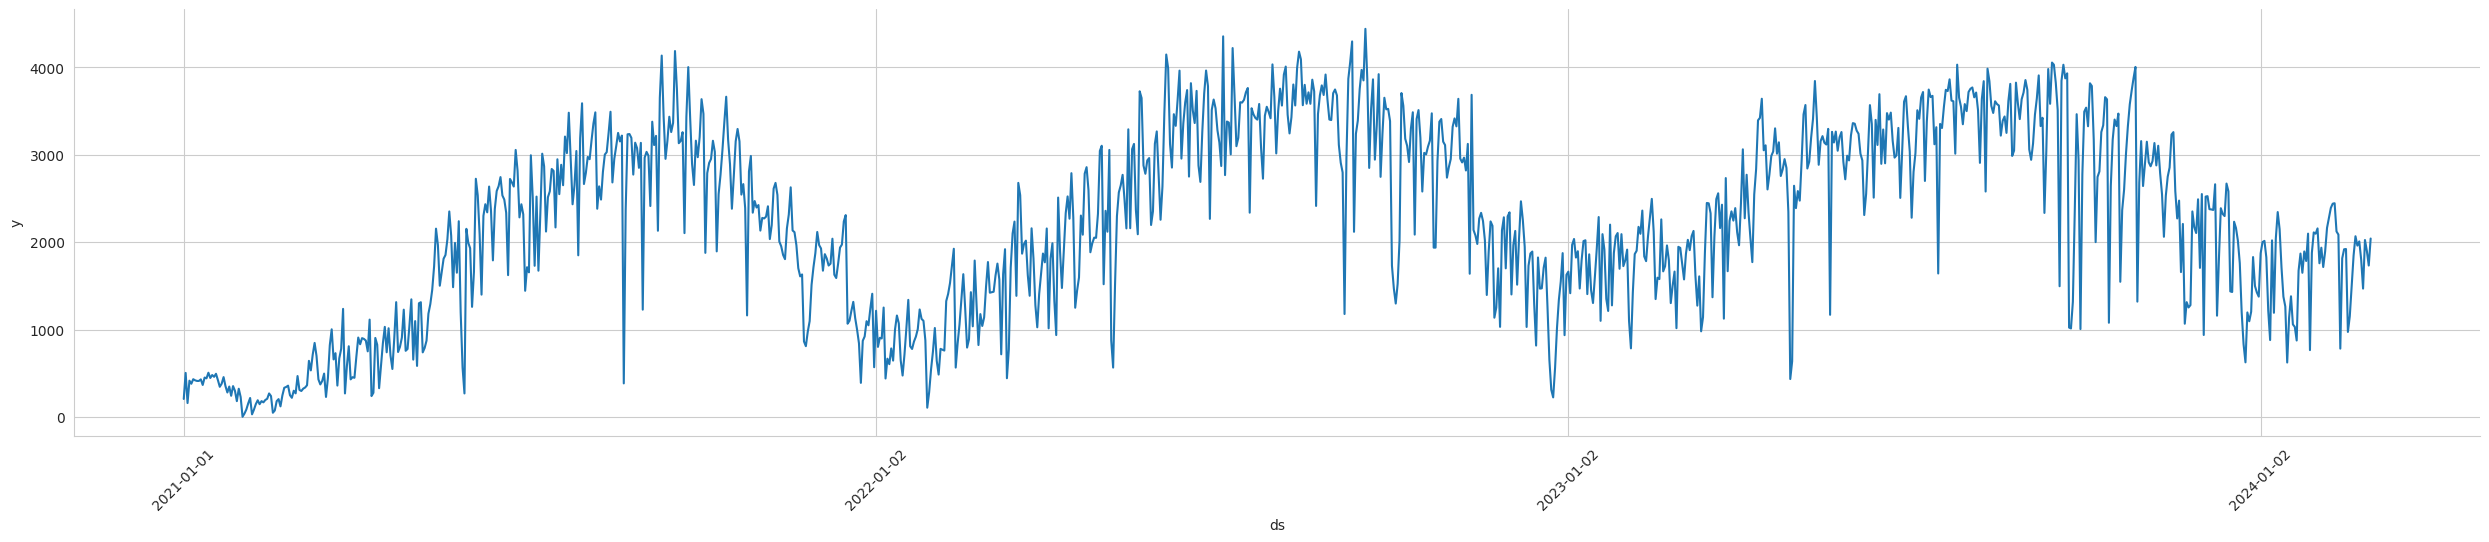

In [29]:
trips_df_pd=df.toPandas()
g = sns.relplot(x="ds", y="y", kind="line", data=trips_df_pd, aspect=5)

x_ticks = trips_df_pd['ds'][::365]   # to display every year
g.set(xticks=x_ticks)

plt.xticks(rotation=45)

plt.show()
g.fig.autofmt_xdate()

In [30]:
len(trips_df_pd)   # Records in the dataset

1154

In [31]:
trips_df_pd['ds'] = pd.to_datetime(trips_df_pd['ds'])

## Time Series Forecasting

### Preparing Dataset

In [32]:
# We first divide our dataset such that we take rides from 2024 as part of testing data and rest as training data

train_data = trips_df_pd[trips_df_pd['ds'].dt.year != 2024]
test_data = trips_df_pd[trips_df_pd['ds'].dt.year == 2024]

print("Training Dataset Size:", len(train_data))
print("Testing Dataset Size:", len(test_data))

Training Dataset Size: 1094
Testing Dataset Size: 60


In [33]:
train_data.head()   # Training data (2021-2023)

ds    y
0 2021-01-01  206
1 2021-01-02  504
2 2021-01-03  159
3 2021-01-04  415
4 2021-01-05  380

In [34]:
train_data.tail() 

ds     y
1089 2023-12-27  1095
1090 2023-12-28  1204
1091 2023-12-29  1830
1092 2023-12-30  1499
1093 2023-12-31  1425

In [35]:
test_data.head()   # Testing data (2024)

ds     y
1094 2024-01-01  1377
1095 2024-01-02  1873
1096 2024-01-03  2002
1097 2024-01-04  2015
1098 2024-01-05  1826

In [36]:
test_data.tail()

ds     y
1149 2024-02-25  1469
1150 2024-02-26  2025
1151 2024-02-27  1900
1152 2024-02-28  1733
1153 2024-02-29  2042

### Training Prophet Model

In [37]:
model=Prophet()
model.fit(train_data)

19:36:51 - cmdstanpy - INFO - Chain [1] start processing
19:36:51 - cmdstanpy - INFO - Chain [1] done processing


In [38]:
### Forcasting using Trained Prophet Model

In [39]:
future = model.make_future_dataframe(periods=60)
forecast = model.predict(future)

In [40]:
forecast.head()

ds        trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2021-01-01  1123.937050 -633.780221  757.082644  1123.937050  1123.937050   
1 2021-01-02  1127.130852 -624.732496  661.429974  1127.130852  1127.130852   
2 2021-01-03  1130.324654 -868.532644  464.545708  1130.324654  1130.324654   
3 2021-01-04  1133.518456 -869.191262  456.170974  1133.518456  1133.518456   
4 2021-01-05  1136.712258 -615.527739  631.431373  1136.712258  1136.712258   

   additive_terms  additive_terms_lower  additive_terms_upper      weekly  \
0    -1084.388359          -1084.388359          -1084.388359   93.488246   
1    -1125.583732          -1125.583732          -1125.583732   48.689067   
2    -1351.124396          -1351.124396          -1351.124396 -183.640796   
3    -1326.641246          -1326.641246          -1326.641246 -168.793348   
4    -1143.380420          -1143.380420          -1143.380420    2.376330   

   weekly_lower  weekly_upper       yearly  yearly_lower  yearly_upper  \
0     93.488246     93.488246 -1177.876605  -1177.876605  -1177.876605   
1     48.689067     48.689067 -1174.272799  -1174.272799  -1174.272799   
2   -183.640796   -183.640796 -1167.483600  -1167.483600  -1167.483600   
3   -168.793348   -168.793348 -1157.847899  -1157.847899  -1157.847899   
4      2.376330      2.376330 -1145.756750  -1145.756750  -1145.756750   

   multiplicative_terms  multiplicative_terms_lower  \
0                   0.0                         0.0   
1                   0.0                         0.0   
2                   0.0                         0.0   
3                   0.0                         0.0   
4                   0.0                         0.0   

   multiplicative_terms_upper        yhat  
0                         0.0   39.548691  
1                         0.0    1.547120  
2                         0.0 -220.799742  
3                         0.0 -193.122790  
4                         0.0   -6.668162

In [41]:
forecast.tail()

ds        trend   yhat_lower   yhat_upper  trend_lower  \
1149 2024-02-25  2488.142166   719.250394  1982.159204  2480.519032   
1150 2024-02-26  2487.596248   758.652393  2062.735661  2479.772167   
1151 2024-02-27  2487.050329   965.112892  2216.905353  2479.011219   
1152 2024-02-28  2486.504411  1042.427763  2315.549029  2478.192367   
1153 2024-02-29  2485.958492  1045.690222  2333.037133  2477.341145   

      trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
1149  2495.228605    -1112.188298          -1112.188298          -1112.188298   
1150  2494.850428    -1088.519397          -1088.519397          -1088.519397   
1151  2494.458788     -909.617787           -909.617787           -909.617787   
1152  2494.240651     -784.748819           -784.748819           -784.748819   
1153  2493.954110     -812.302183           -812.302183           -812.302183   

          weekly  weekly_lower  weekly_upper      yearly  yearly_lower  \
1149 -183.640796   -183.640796   -183.640796 -928.547502   -928.547502   
1150 -168.793348   -168.793348   -168.793348 -919.726049   -919.726049   
1151    2.376330      2.376330      2.376330 -911.994117   -911.994117   
1152  120.567097    120.567097    120.567097 -905.315916   -905.315916   
1153   87.313405     87.313405     87.313405 -899.615588   -899.615588   

      yearly_upper  multiplicative_terms  multiplicative_terms_lower  \
1149   -928.547502                   0.0                         0.0   
1150   -919.726049                   0.0                         0.0   
1151   -911.994117                   0.0                         0.0   
1152   -905.315916                   0.0                         0.0   
1153   -899.615588                   0.0                         0.0   

      multiplicative_terms_upper         yhat  
1149                         0.0  1375.953868  
1150                         0.0  1399.076851  
1151                         0.0  1577.432543  
1152                         0.0  1701.755592  
1153                         0.0  1673.656309

'ds': represents the dates for which the forecasted values are provided. \
'yhat': contains the forecasted values (predictions) for each corresponding date in the 'ds' column. \
'yhat_lower': contains the lower bound of the uncertainty interval for each forecasted value. It represents the lower bound of the prediction's confidence interval. \
'yhat_upper': contains the upper bound of the uncertainty interval for each forecasted value. It represents the upper bound of the prediction's confidence interval.

In [42]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds         yhat   yhat_lower   yhat_upper
1149 2024-02-25  1375.953868   719.250394  1982.159204
1150 2024-02-26  1399.076851   758.652393  2062.735661
1151 2024-02-27  1577.432543   965.112892  2216.905353
1152 2024-02-28  1701.755592  1042.427763  2315.549029
1153 2024-02-29  1673.656309  1045.690222  2333.037133

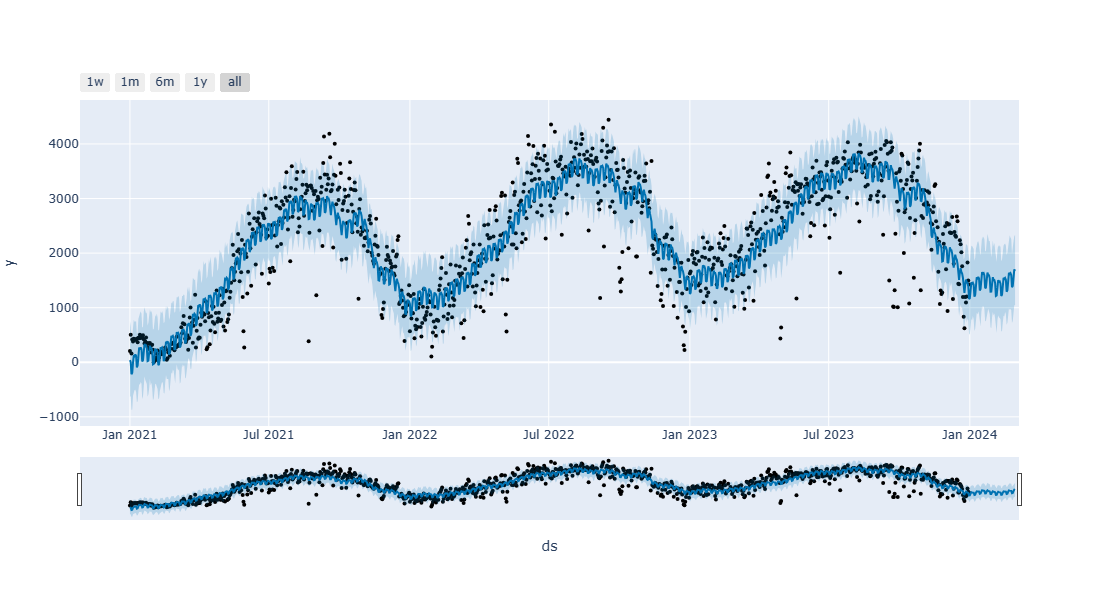

In [43]:
# This plot shows the forecast generated by the Prophet model.
plot_plotly(model ,forecast)

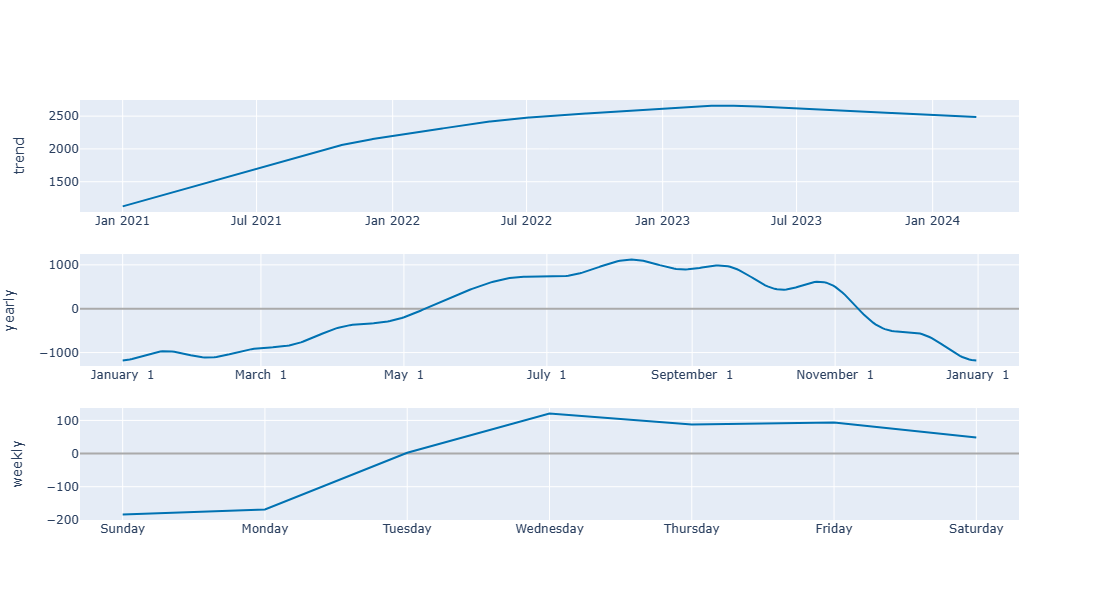

In [44]:
# This plot shows the yearly, weakly and general trend generated by the Prophet model.
plot_components_plotly(model, forecast)

In [45]:
# These are the predicted values for the year 2024.
predictions = forecast[forecast['ds'].dt.year == 2024]['yhat']
predictions

1094    1171.054905
1095    1342.707500
1096    1464.781071
1097    1438.516257
1098    1454.433227
1099    1421.726875
1100    1203.398631
1101    1233.686426
1102    1421.248681
1103    1556.293267
1104    1539.871016
1105    1562.390143
1106    1533.012974
1107    1314.787248
1108    1342.073601
1109    1523.725162
1110    1650.210376
1111    1622.898801
1112    1632.566471
1113    1588.782457
1114    1355.029208
1115    1366.118536
1116    1531.359510
1117    1641.669667
1118    1598.849592
1119    1594.077745
1120    1537.287426
1121    1292.278695
1122    1294.127314
1123    1452.347137
1124    1557.997462
1125    1512.955489
1126    1508.410757
1127    1454.243470
1128    1214.139414
1129    1223.003467
1130    1390.127941
1131    1506.307113
1132    1473.117853
1133    1481.423011
1134    1440.759180
1135    1214.461329
1136    1237.085983
1137    1417.588979
1138    1546.448877
1139    1524.955714
1140    1543.721565
1141    1512.074336
1142    1293.187155
1143    1321.504932


## Evaluation

In [46]:
# Calculate Root Mean Squared Error (RMSE)
mse = mean_squared_error(y_true=test_data['y'], y_pred=predictions)
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)

Root Mean Squared Error (RMSE): 523.6545071149424


In [47]:
# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_true=test_data['y'],  y_pred=predictions)
print("Mean Absolute Error (MAE):", mae)

Mean Absolute Error (MAE): 460.6661489598488


In [48]:
# Calculate Mean Absolute Percentage Error (MAPE)
mape = mean_absolute_percentage_error(y_true=test_data['y'], y_pred=predictions)
print("Mean Absolute Percentage Error (MAPE):", mape)

Mean Absolute Percentage Error (MAPE): 0.2894123578095799


#### Plot comparing the actual and predicted values for the test data.

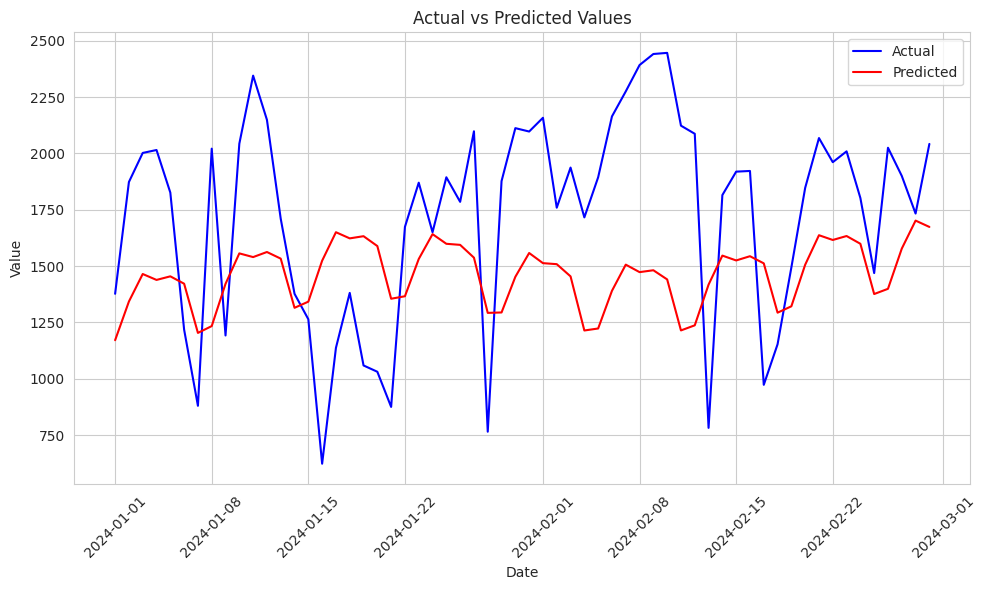

In [49]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(test_data['ds'], test_data['y'], label='Actual', color='blue')
plt.plot(test_data['ds'], predictions, label='Predicted', color='red')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual vs Predicted Values')
plt.xticks(rotation=45)  
plt.legend()
plt.tight_layout() 
plt.show()


# Adding Holidays/Special Events

In this section, we will see how adding holidays/Events effects the forecasted results

In [50]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

cal = calendar()

# Get the holidays
holidays = cal.holidays(start='2021-01-01', end='2024-02-29',return_name=True)

# Print the list of holidays
print("US Federal Holidays from 2021-2024:")
print(holidays)

US Federal Holidays from 2021-2024:
2021-01-01                          New Year's Day
2021-01-18     Birthday of Martin Luther King, Jr.
2021-02-15                   Washington's Birthday
2021-05-31                            Memorial Day
2021-06-18    Juneteenth National Independence Day
2021-07-05                        Independence Day
2021-09-06                               Labor Day
2021-10-11                            Columbus Day
2021-11-11                            Veterans Day
2021-11-25                        Thanksgiving Day
2021-12-24                           Christmas Day
2021-12-31                          New Year's Day
2022-01-17     Birthday of Martin Luther King, Jr.
2022-02-21                   Washington's Birthday
2022-05-30                            Memorial Day
2022-06-20    Juneteenth National Independence Day
2022-07-04                        Independence Day
2022-09-05                               Labor Day
2022-10-10                            Columbus

In [51]:
holiday_df = pd.DataFrame(data=holidays,columns=['holiday'])

In [52]:
holiday_df = holiday_df.reset_index().rename(columns={'index':'ds'})
holiday_df

ds                               holiday
0  2021-01-01                        New Year's Day
1  2021-01-18   Birthday of Martin Luther King, Jr.
2  2021-02-15                 Washington's Birthday
3  2021-05-31                          Memorial Day
4  2021-06-18  Juneteenth National Independence Day
5  2021-07-05                      Independence Day
6  2021-09-06                             Labor Day
7  2021-10-11                          Columbus Day
8  2021-11-11                          Veterans Day
9  2021-11-25                      Thanksgiving Day
10 2021-12-24                         Christmas Day
11 2021-12-31                        New Year's Day
12 2022-01-17   Birthday of Martin Luther King, Jr.
13 2022-02-21                 Washington's Birthday
14 2022-05-30                          Memorial Day
15 2022-06-20  Juneteenth National Independence Day
16 2022-07-04                      Independence Day
17 2022-09-05                             Labor Day
18 2022-10-10                          Columbus Day
19 2022-11-11                          Veterans Day
20 2022-11-24                      Thanksgiving Day
21 2022-12-26                         Christmas Day
22 2023-01-02                        New Year's Day
23 2023-01-16   Birthday of Martin Luther King, Jr.
24 2023-02-20                 Washington's Birthday
25 2023-05-29                          Memorial Day
26 2023-06-19  Juneteenth National Independence Day
27 2023-07-04                      Independence Day
28 2023-09-04                             Labor Day
29 2023-10-09                          Columbus Day
30 2023-11-10                          Veterans Day
31 2023-11-23                      Thanksgiving Day
32 2023-12-25                         Christmas Day
33 2024-01-01                        New Year's Day
34 2024-01-15   Birthday of Martin Luther King, Jr.
35 2024-02-19                 Washington's Birthday

In [53]:
COVID_Pandemic = pd.DataFrame ({
    'ds':pd.date_range('2020-03-15','2023-03-01'),
     'holiday':'COVID'
})

COVID_Pandemic

ds holiday
0    2020-03-15   COVID
1    2020-03-16   COVID
2    2020-03-17   COVID
3    2020-03-18   COVID
4    2020-03-19   COVID
...         ...     ...
1077 2023-02-25   COVID
1078 2023-02-26   COVID
1079 2023-02-27   COVID
1080 2023-02-28   COVID
1081 2023-03-01   COVID

[1082 rows x 2 columns]

In [54]:
holiday_df = pd.concat((holiday_df,COVID_Pandemic))
holiday_df

ds                               holiday
0    2021-01-01                        New Year's Day
1    2021-01-18   Birthday of Martin Luther King, Jr.
2    2021-02-15                 Washington's Birthday
3    2021-05-31                          Memorial Day
4    2021-06-18  Juneteenth National Independence Day
...         ...                                   ...
1077 2023-02-25                                 COVID
1078 2023-02-26                                 COVID
1079 2023-02-27                                 COVID
1080 2023-02-28                                 COVID
1081 2023-03-01                                 COVID

[1118 rows x 2 columns]

In [55]:
model_with_holiday=Prophet(holidays=holiday_df)   # adding holiday factor to prophet
model_with_holiday.fit(train_data)

19:36:55 - cmdstanpy - INFO - Chain [1] start processing
19:36:55 - cmdstanpy - INFO - Chain [1] done processing


In [56]:
future = model_with_holiday.make_future_dataframe(periods=60)  #makeing predictions
forecast = model_with_holiday.predict(future)

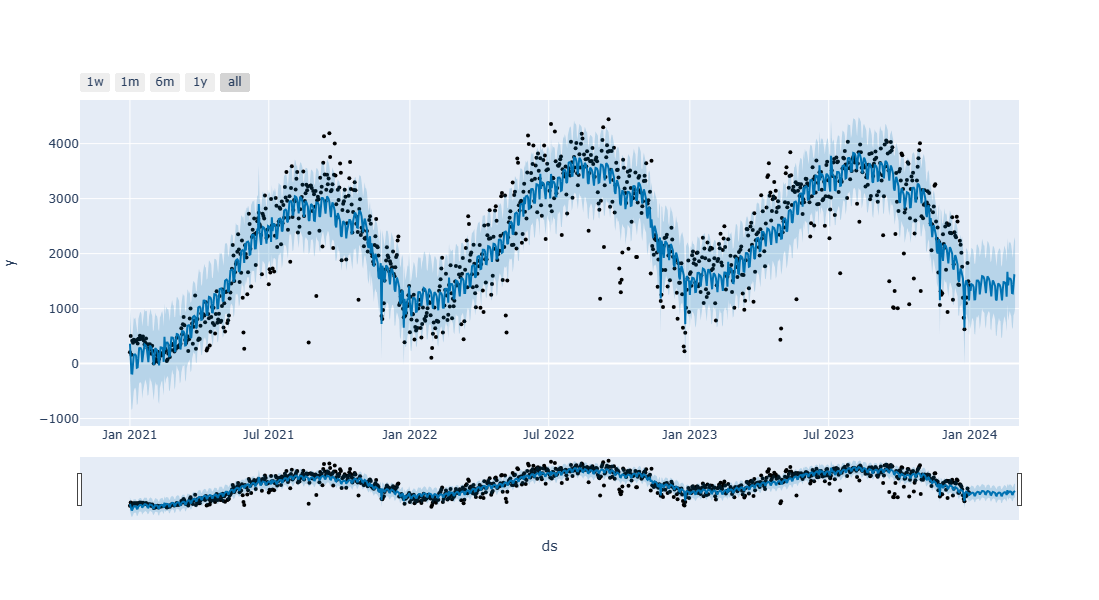

In [57]:
plot_plotly(model_with_holiday ,forecast)

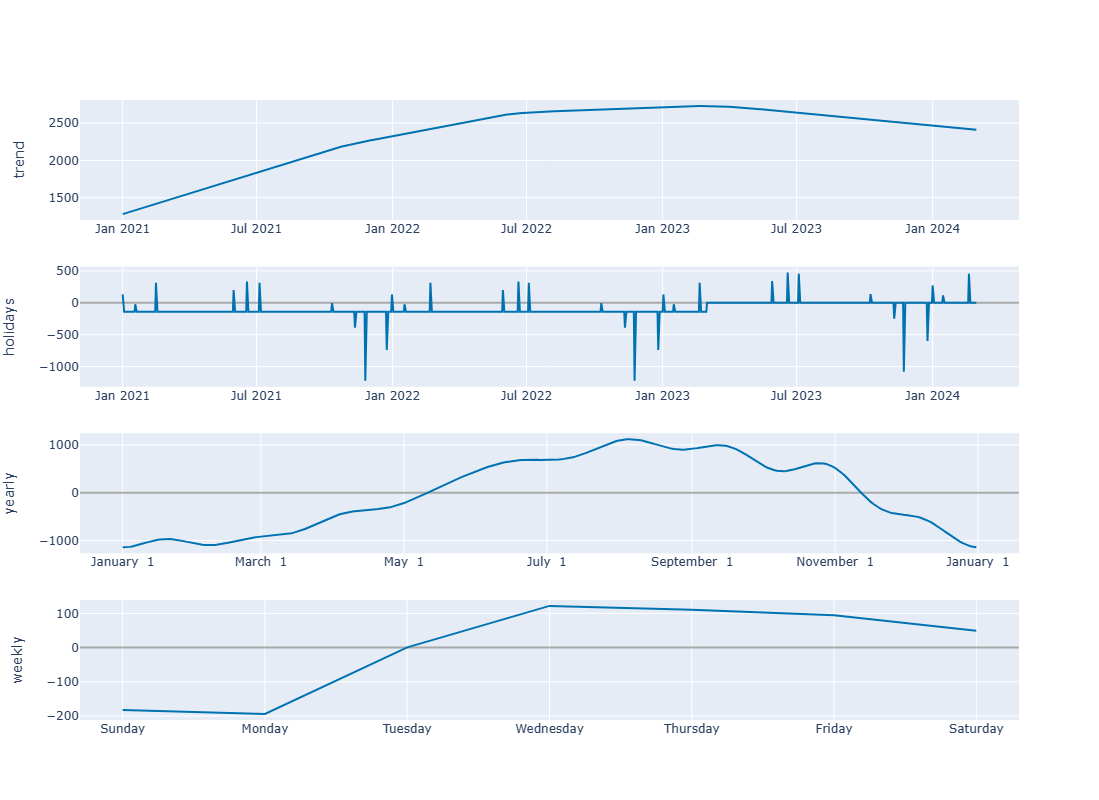

In [58]:
plot_components_plotly(model_with_holiday, forecast)

In [59]:
predictions = forecast[forecast['ds'].dt.year == 2024]['yhat']
predictions

1094    1402.668820
1095    1322.664768
1096    1444.087205
1097    1435.736881
1098    1425.849121
1099    1389.008919
1100    1167.090777
1101    1167.430172
1102    1375.266288
1103    1509.979647
1104    1512.206723
1105    1510.056479
1106    1478.056378
1107    1258.092428
1108    1374.887463
1109    1461.899018
1110    1590.635548
1111    1584.681556
1112    1572.448392
1113    1528.803524
1114    1296.001356
1115    1281.843425
1116    1472.107892
1117    1586.772358
1118    1567.112491
1119    1541.901815
1120    1486.340675
1121    1242.979366
1122    1219.871729
1123    1402.999329
1124    1512.490311
1125    1489.715547
1126    1463.487418
1127    1408.989282
1128    1168.700544
1129    1150.553575
1130    1340.362459
1131    1458.047549
1132    1444.738239
1133    1428.979128
1134    1385.667405
1135    1156.986148
1136    1150.569566
1137    1351.939930
1138    1480.739965
1139    1477.842899
1140    1471.565164
1141    1436.609414
1142    1215.002422
1143    1667.458818


## Evaluation

In [60]:
# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_true=test_data['y'], y_pred=predictions)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

print("Root Mean Squared Error (RMSE):", rmse)

Root Mean Squared Error (RMSE): 552.3462401951427


In [61]:
# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_true=test_data['y'],  y_pred=predictions)
print("Mean Absolute Error (MAE):", mae)

Mean Absolute Error (MAE): 489.1196636552094


In [62]:
# Calculate Mean Absolute Percentage Error (MAPE)
mape = mean_absolute_percentage_error(y_true=test_data['y'], y_pred=predictions)
print("Mean Absolute Percentage Error (MAPE):", mape)

Mean Absolute Percentage Error (MAPE): 0.2974552993945298


#### Plot comparing the actual and predicted values for the test data.

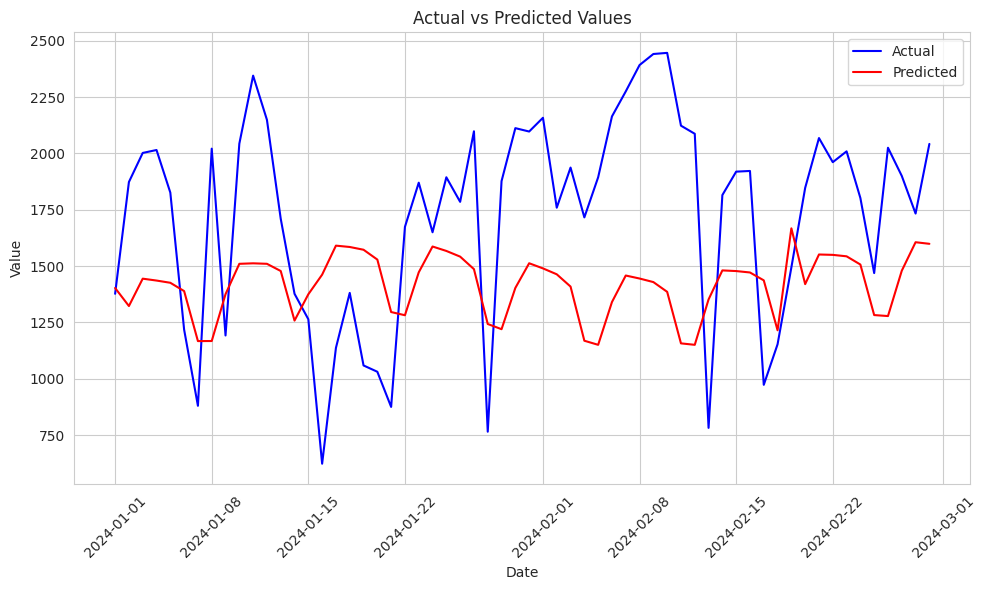

In [63]:
import matplotlib.pyplot as plt

# Plot actual vs predicted values with dates
plt.figure(figsize=(10, 6))
plt.plot(test_data['ds'], test_data['y'], label='Actual', color='blue')
plt.plot(test_data['ds'], predictions, label='Predicted', color='red')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual vs Predicted Values')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend()
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()


## Adding Weather Effect

In [64]:
weather_object = spark.read.csv('data/weather.csv', sep=',',inferSchema=True, header=True)
weather_object=weather_object.select("DATE","PRCP","SNOW")
weather_object

DataFrame[DATE: date, PRCP: double, SNOW: double]

In [65]:
start_date = '2021-01-01'
end_date = '2024-02-29'
weather_df = weather_object.filter((col('DATE') >= start_date) & (col('DATE') <= end_date))
weather_object

DataFrame[DATE: date, PRCP: double, SNOW: double]

In [66]:
# Merge trip data with weather data
weather_df = weather_df.withColumn('DATE', weather_df['DATE'].cast('timestamp'))
trips_df_spark = spark.createDataFrame(trips_df_pd)
merged_df = trips_df_spark.join(weather_df, trips_df_spark['ds'] == weather_df['DATE'], how='left')
merged_df = merged_df.drop('DATE')
merged_df_pd=merged_df.toPandas()
merged_df_pd['ds'] = pd.to_datetime(merged_df_pd['ds'])
merged_df_pd

ds     y   PRCP  SNOW
0    2021-01-01   206  157.0   0.0
1    2021-01-02   504   13.0   0.0
2    2021-01-03   159   56.0   0.0
3    2021-01-04   415    5.0   0.0
4    2021-01-05   380    0.0   0.0
...         ...   ...    ...   ...
1149 2024-02-25  1469    0.0   0.0
1150 2024-02-26  2025    3.0   0.0
1151 2024-02-27  1900  132.0   0.0
1152 2024-02-28  1733   43.0   0.0
1153 2024-02-29  2042    0.0   0.0

[1154 rows x 4 columns]

In [67]:
train_data = merged_df_pd[merged_df_pd['ds'].dt.year != 2024]
test_data = merged_df_pd[merged_df_pd['ds'].dt.year == 2024]

print("Training Dataset Size:", len(train_data))
print("Testing Dataset Size:", len(test_data))

Training Dataset Size: 1094
Testing Dataset Size: 60


In [68]:
model_weather=Prophet(holidays=holiday_df)  # adding holidays effects
model_weather.add_regressor('PRCP')         # adding precipitation effect
model_weather.add_regressor('SNOW')         # adding snow effect
model_weather.fit(train_data)

19:37:03 - cmdstanpy - INFO - Chain [1] start processing
19:37:03 - cmdstanpy - INFO - Chain [1] done processing


In [69]:
def weather_PRCP(date):
    date = date.to_pydatetime().date()
    
    # Check if the date exists in historical weather data
    if weather_df.filter(weather_df['DATE'] == date).count() > 0: 
        return weather_df.filter(weather_df['DATE'] == date).select('PRCP').collect()[0]['PRCP'] #fetch the corresponding precipitate value
    else:
        return 0

def weather_SNOW(date):
    date = date.to_pydatetime().date()
    
    # Check if the date exists in historical weather data
    if weather_df.filter(weather_df['DATE'] == date).count() > 0: 
        return weather_df.filter(weather_df['DATE'] == date).select('SNOW').collect()[0]['SNOW'] #fetch the corresponding snow value
    else:
        return 0

In [70]:
future = model_weather.make_future_dataframe(periods=60)  #makeing predictions
future['PRCP'] = future['ds'].apply(weather_PRCP)
future['SNOW'] = future['ds'].apply(weather_SNOW)
forecast = model_weather.predict(future)

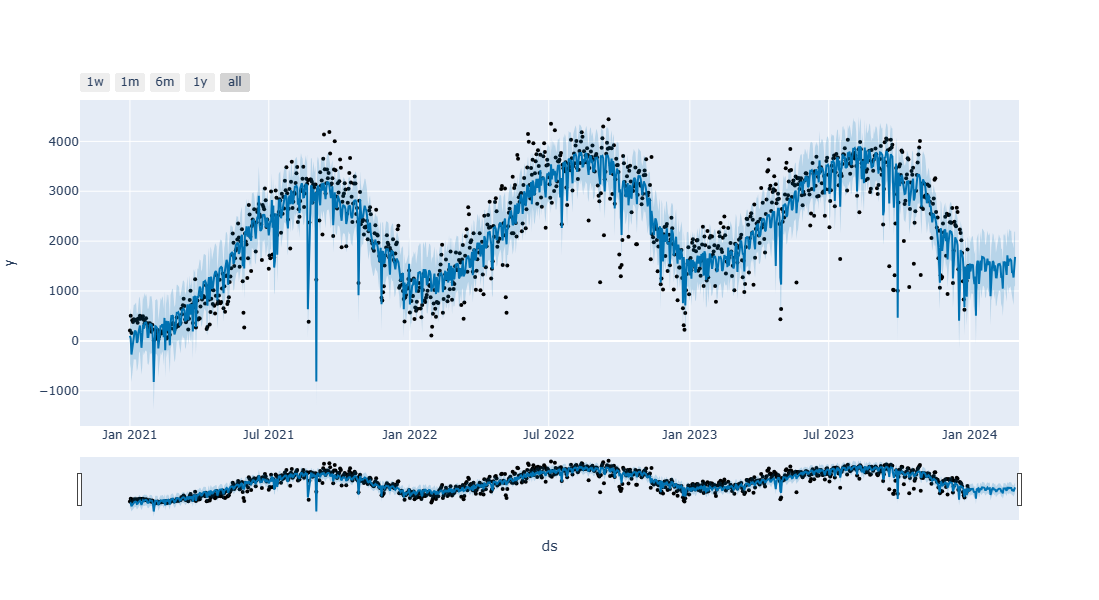

In [71]:
plot_plotly(model_weather ,forecast)

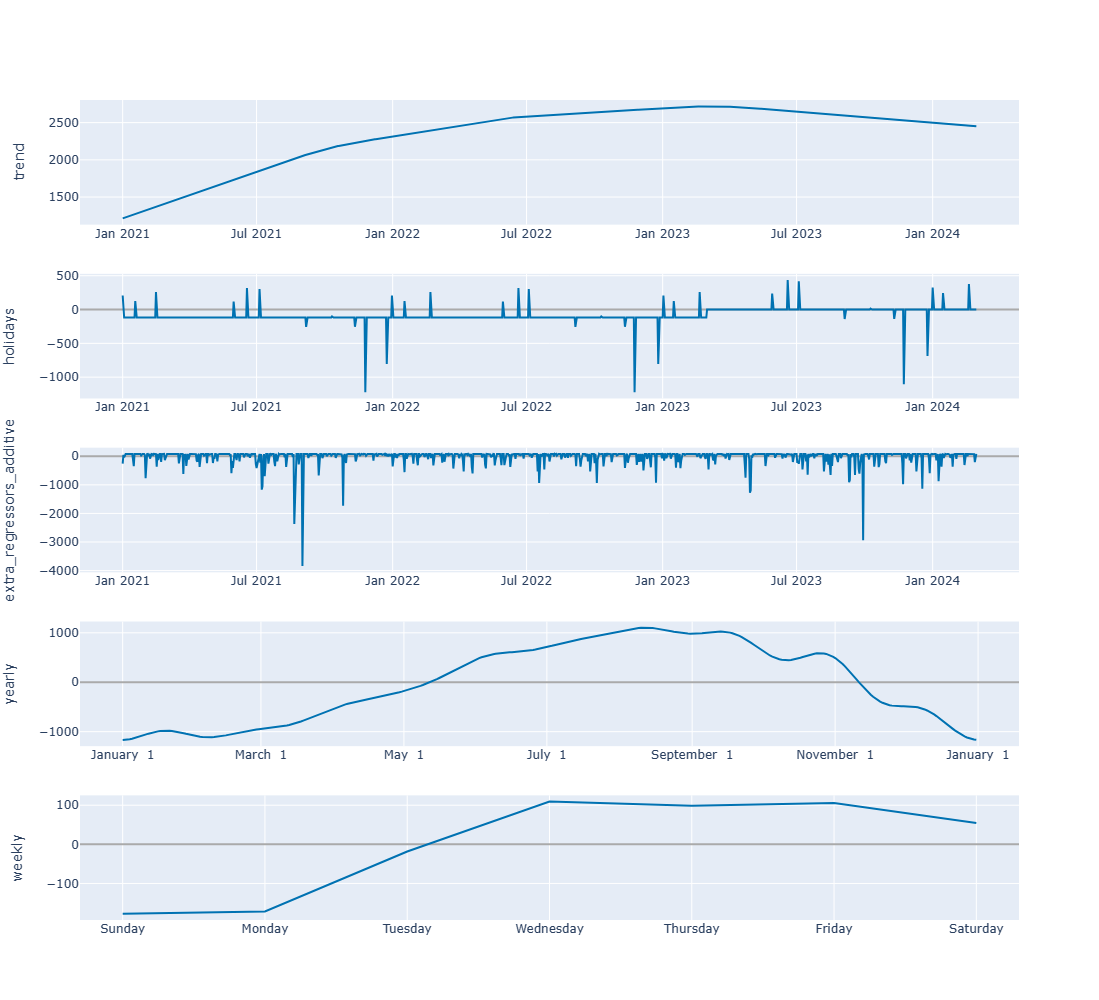

In [72]:
plot_components_plotly(model_weather, forecast)

In [73]:
predictions = forecast[forecast['ds'].dt.year == 2024]['yhat']
predictions

1094    1550.292053
1095    1394.274981
1096    1523.176517
1097    1516.746082
1098    1531.145751
1099    1266.745394
1100    1137.575045
1101    1288.836766
1102     505.221219
1103    1477.937313
1104    1603.473832
1105    1581.934543
1106    1141.783292
1107    1369.193220
1108    1612.269266
1109    1410.121948
1110    1684.502074
1111    1678.976101
1112    1671.959754
1113    1639.092697
1114    1405.778534
1115    1407.959724
1116    1527.781770
1117    1648.006497
1118    1524.121426
1119    1549.173647
1120    1591.080084
1121     896.483156
1122    1312.735381
1123    1482.330231
1124    1598.106979
1125    1576.009183
1126    1397.249176
1127    1512.750371
1128    1273.080837
1129    1272.590137
1130    1421.571761
1131    1546.305148
1132    1534.281744
1133    1541.990776
1134    1493.339633
1135    1265.302072
1136    1276.358081
1137    1047.652960
1138    1571.798583
1139    1569.461651
1140    1585.799591
1141    1467.506063
1142    1322.612253
1143    1714.489369


## Evaluation

In [74]:
# Calculate Root Mean Squared Error (RMSE)
mse = mean_squared_error(y_true=test_data['y'], y_pred=predictions)
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)

Root Mean Squared Error (RMSE): 509.7273253976055


In [75]:
# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_true=test_data['y'],  y_pred=predictions)
print("Mean Absolute Error (MAE):", mae)

Mean Absolute Error (MAE): 454.5392422814608


In [76]:
# Calculate Mean Absolute Percentage Error (MAPE)
mape = mean_absolute_percentage_error(y_true=test_data['y'], y_pred=predictions)
print("Mean Absolute Percentage Error (MAPE):", mape)

Mean Absolute Percentage Error (MAPE): 0.27892411267825706


#### Plot comparing the actual and predicted values for the test data.

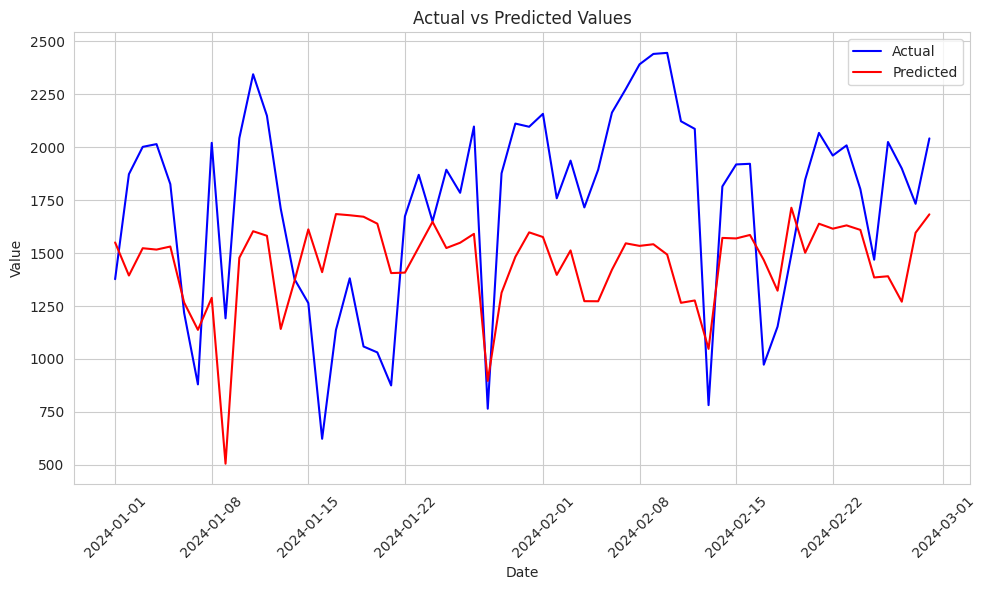

In [77]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(test_data['ds'], test_data['y'], label='Actual', color='blue')
plt.plot(test_data['ds'], predictions, label='Predicted', color='red')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual vs Predicted Values')
plt.xticks(rotation=45)  
plt.legend()
plt.tight_layout() 
plt.show()